# import stuff 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import objectives
from keras.datasets import mnist
from keras import backend as K

Using Theano backend.
Using gpu device 0: TITAN X (Pascal) (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5105)


# encoder/decode network size

In [2]:
batch_size=100
digit_size=28
original_dim=784
intermediate_dim=256
latent_dim=2

nb_epochs=50
epsilon_std=1.0

# encoder

In [3]:
X=Input(batch_shape=(batch_size,original_dim))
h=Dense(intermediate_dim, activation='relu')(X)
z_mean=Dense(latent_dim)(h)
z_log_var=Dense(latent_dim)(h)

# sampling from latent for decoder

In [4]:
def sampling(args):
    _mean,_log_var=args
    epsilon=K.random_normal(shape=(batch_size, latent_dim), mean=0., std=epsilon_std)
    return _mean+K.exp(_log_var/2)*epsilon

# a keras lambda layer computes arbitrary function on the output of a layer
# so z is effectively combining mean and variance layers through sampling func 
z= Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# decoder

In [5]:
h_decoder=Dense(intermediate_dim, activation='relu')
X_bar=Dense(original_dim,activation='sigmoid')

# we instantiate these layers separately so as to reuse them later
h_decoded = h_decoder(z)
X_decoded = X_bar(h_decoded)

# VAE loss

In [6]:
def vae_loss(x,x_bar):
    reconst_loss=original_dim*objectives.binary_crossentropy(x, x_bar)
    kl_loss=-0.5*K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return reconst_loss + kl_loss

# compile model and prepare data for training

In [7]:
# build and compile model
vae=Model(X , X_decoded)
vae.compile(optimizer='adam', loss=vae_loss)

# load MNIST data for training
(x_train, y_train),(x_test, y_test)=mnist.load_data()

# normalize input and make them float32 to run on GPU
x_train=x_train.astype('float32')/ 255.
x_test=x_test.astype('float32')/255.

# convert 28x28 images into 784-vectors
x_train=x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test=x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# train model based on the loss func we defined

In [8]:
# x_train is required for input and loss output as target
vae.fit(x_train,x_train, shuffle=True, nb_epoch=nb_epochs, batch_size=batch_size, validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 0s - loss: 198.6994 - val_loss: 173.1797
Epoch 2/50
60000/60000 [==============================] - 0s - loss: 169.7201 - val_loss: 167.3313
Epoch 3/50
60000/60000 [==============================] - 0s - loss: 166.0421 - val_loss: 165.0154
Epoch 4/50
60000/60000 [==============================] - 0s - loss: 164.0876 - val_loss: 163.4975
Epoch 5/50
60000/60000 [==============================] - 0s - loss: 162.6531 - val_loss: 162.1774
Epoch 6/50
60000/60000 [==============================] - 0s - loss: 161.4048 - val_loss: 161.0974
Epoch 7/50
60000/60000 [==============================] - 0s - loss: 160.2301 - val_loss: 160.1707
Epoch 8/50
60000/60000 [==============================] - 0s - loss: 159.1471 - val_loss: 158.8818
Epoch 9/50
60000/60000 [==============================] - 0s - loss: 158.0001 - val_loss: 158.1075
Epoch 10/50
60000/60000 [==============================] - 

# Let's play with inference and the generative models we trained!

The encoder network can embed the 28x28 images in its latent space. As you can see, it can even cluster them!

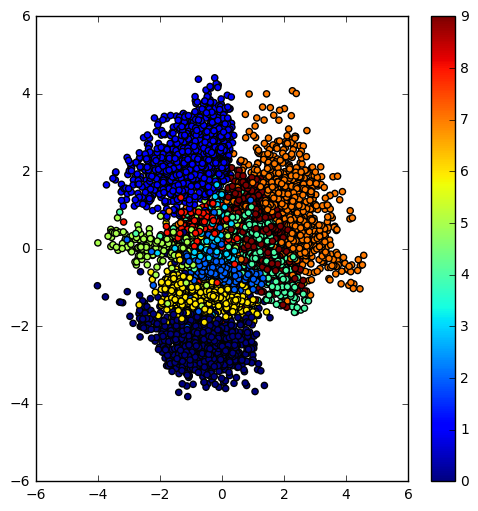

In [9]:
# encoder is the inference network
encoder=Model(X, z_mean)

# a 2d plot of 10 digit classes in latent space
x_test_encoded=encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6,6))
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=y_test)
plt.colorbar()
plt.show()

Now that we have learned the latent space distribution, we can sample from it and the decoder network maps it to an image similar to our data. So we can now generate images. Pretty cool, eh !?

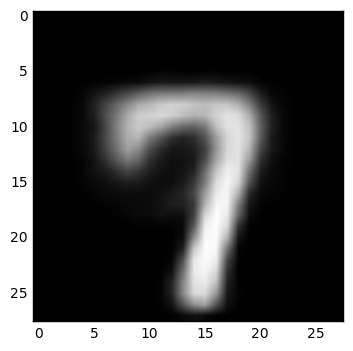

In [10]:
# since the generator treats z as an input, we make z an input layer
z_input=Input(shape=(latent_dim,))
_h_decoded=h_decoder(z_input)
_x_decoded=X_bar(_h_decoded)
generator= Model(z_input, _x_decoded)

z_sample=np.array([np.random.normal(0, 1, 2)])
x_decoded=generator.predict(z_sample)
sampled_im=x_decoded[0].reshape(digit_size,digit_size)
plt.imshow(sampled_im, cmap='Greys_r')
plt.show()

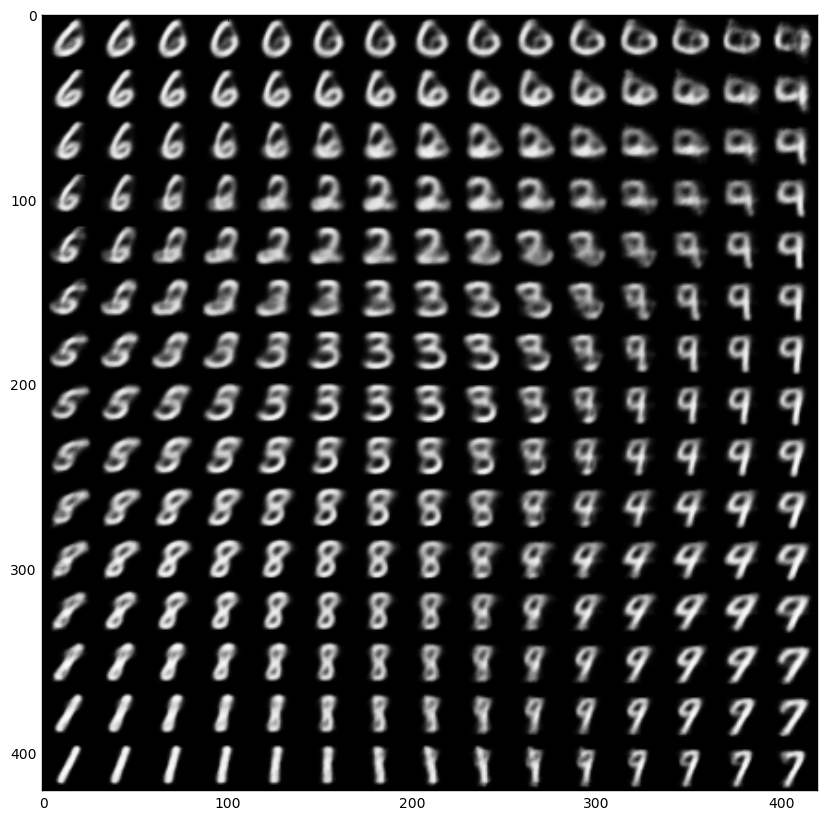

In [11]:
# 2d manifold of images by exploring quantiles of normal dist (using the inverse of cdf)
n=15
figure = np.zeros((digit_size*n, digit_size*n))

grid_x=norm.ppf(np.linspace(0.05,0.95,n))
grid_y=norm.ppf(np.linspace(0.05,0.95,n))

for i, yi in enumerate(grid_x):
    for j,xi in enumerate(grid_y):
        z_sample=np.array([[xi,yi]])
        x_decoded=generator.predict(z_sample)
        digit=x_decoded[0].reshape(digit_size,digit_size)
        figure[i*digit_size:(i+1)*digit_size, 
              j*digit_size:(j+1)*digit_size]=digit
        
plt.figure(figsize=(10,10))
plt.imshow(figure, cmap='Greys_r')
plt.show()